# Declipping

Given a clipped audio signal, we want to use interpolation to estimate/restore the signal at its clipped segments.   

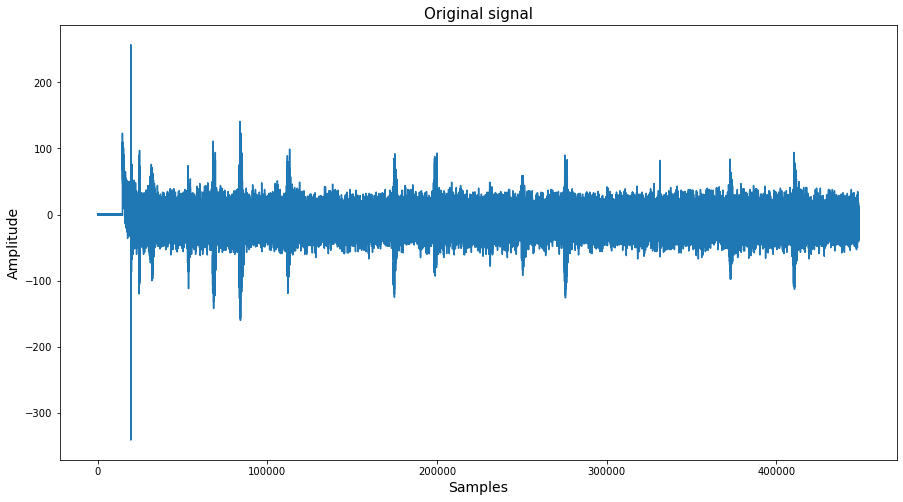

In [22]:
from scipy.io.wavfile import read, write
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'output.wav'

# convert the wav file into a numpy array
sample_rate, file_data = read(filename)
audio_data = np.array(file_data, dtype=float)

# amplitude extremes (useful to determine if a sample is inside a clipped segment or not)
max_ampl = audio_data.max()
min_ampl = audio_data.min()

# amplitude abs max 
old_max = max(abs(audio_data))  

# plot the signal
plt.figure(figsize=(15, 8))
plt.title('Original signal', fontsize=15)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.plot(audio_data)
plt.show()


## Identification of the clipped segments

**GOAL:** Return a list of all of the *clipped segments, that is, the samples affected by clipping*.

Additionally, we want to keep track of whether or not we are currently inside of a clipped segment, as well as the start and end indices of the current clipped segment.

For each sample, 2 interesting cases can occur:
1. **If the sample is inside of a clipped segment and we haven’t determined yet that we are inside of a clipped segment,** then we declare that we are indeed in a clipped segment, and this clipped sample is the first clipped sample of that segment.
2. **If now we are not inside of a clipped segment, but we were before,** then we can identify the previous sample as the end of that segment. At this point we know the start and end of our clipped segment, so we can add it to our list of clipped segments.

In [23]:
# initialization
clipped_segments = []
inside_clip = False
clip_start = 0
clip_end = 0

# loop through the samples in the array
for i, sample in enumerate(audio_data):
    
    # is the sample equal to or extremely close to max or min??
    if (sample <= min_ampl + 1) or (sample >= max_ampl - 1):
        
        if not inside_clip:
            # define it as a clipped segment
            inside_clip = True
            # this is the first clipped sample
            clip_start = i
            
    elif inside_clip:
        inside_clip = False # no longer inside clipped segment
        clip_end = i-1  # previous sample is the end of segment
        
        # save segment
        clipped_segment = (clip_start, clip_end)
        # store it in list of clipped segments
        clipped_segments.append(clipped_segment)

## Fixing the segments

We can estimate what the not clipped signal would have looked like using interpolation. To do this, we will loop through each of the clipped segments and declip them one by one.

Note that we want to use cubic interpolation, as opposed to linear, to accommodate for the curvy shape of the waveform. 

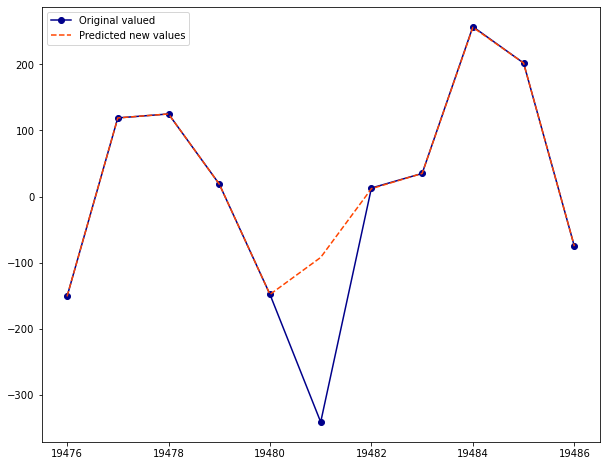

In [24]:
declipped_audio = audio_data.copy()  # make copy of original np_array, we will edit it
plot_clipped = False                 # plot only the first clipped segment

for segment in clipped_segments:
    
    # get few (5) samples surrounding the segment that are not clipped
    start = segment[0]
    end = segment[1]
    
    x_true = list(range(start - 5, start)) + list(range(end + 1, end + 6))
    y_true = [audio_data[i] for i in x_true]
    
    # function to predict missing values    
    interpolation_function = interp1d(x_true, y_true, kind='cubic')
    # indices to pass through function (extended clipped segment)
    x_axis = list(range(start - 5, end + 6))
    # new sample values
    y_axis_new = [float(int(i)) for i in interpolation_function(x_axis)]
    
       
    if not plot_clipped: 
        plot_clipped = True
        
        y_axis_old = [audio_data[i] for i in x_axis]  
        plt.figure(figsize=(10, 8))
        plt.plot(x_axis, y_axis_old, 'o-', color='darkblue', label='Original valued')
        plt.plot(x_axis, y_axis_new, '--', color='orangered', label='Predicted new values')
        plt.legend()
        plt.show()
    
    # update declipped data
    for i, x in enumerate(x_axis):
        if start <= x <= end:
            declipped_audio[x] = y_axis_new[i]

## Plot of the declipped signal

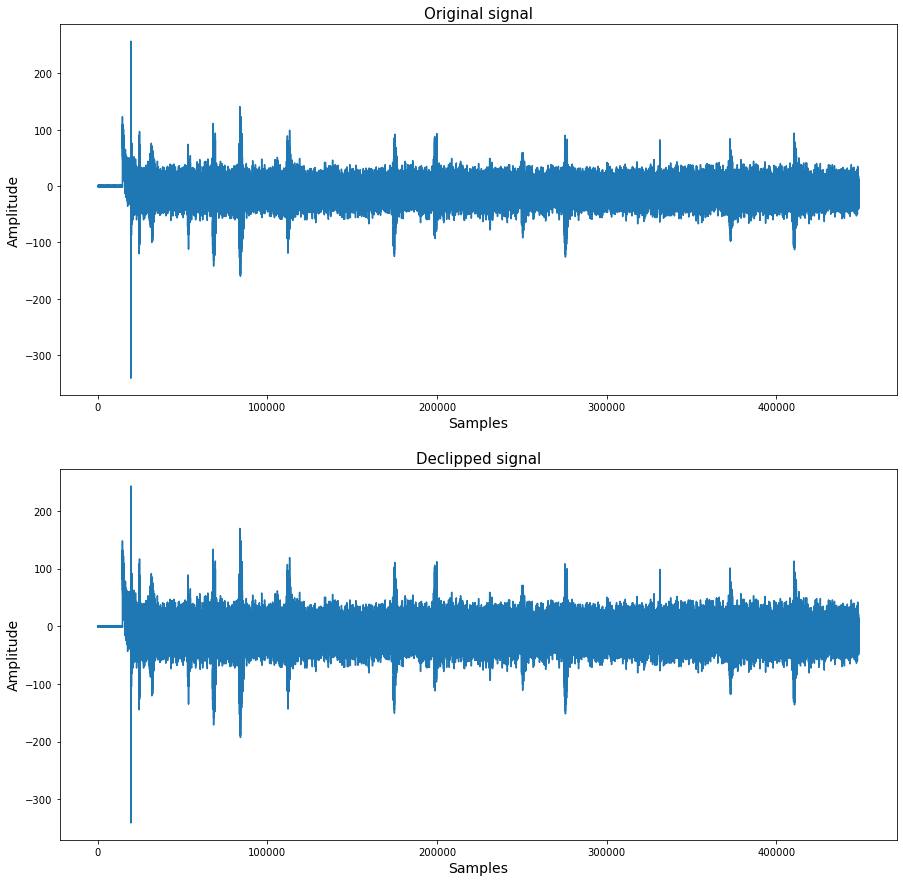

In [27]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 15))

ax0.set_title('Original signal', fontsize=15)
ax0.set_xlabel('Samples', fontsize=14)
ax0.set_ylabel('Amplitude', fontsize=14)
ax0.plot(audio_data)

ax1.set_title('Declipped signal', fontsize=15)
ax1.set_xlabel('Samples', fontsize=14)
ax1.set_ylabel('Amplitude', fontsize=14)
ax1.plot(declipped_audio)

plt.savefig('output_images/declipping.png',  bbox_inches='tight')
plt.show()

## Save the restored audio as wav file

In [26]:
# scale the signal to make it within the original limits

new_max = max(abs(declipped_audio))                                 # find new maximum
declipped_audio = declipped_audio/new_max*old_max.astype('int16')   # 16-bit

write("declipped_audio.wav", sample_rate, declipped_audio)